## Setup

In [2]:
home <- "/home/workspace/"
path <- "pbmc_flow/data/NDMM PM1 data - Statistics (1).csv"
util <- "pbmc_flow/utils.R"
long_util <- "pbmc_flow/notebooks/flu_response_longitudinal/longitudinal_utils.R"

source(file.path(home, util))
source(file.path(home, long_util))

df <- fread(file.path(home, path))
df <- df[df$plate != "B196", ]
df$subject <- df$Subject
df$visit <- df$Visit
df$cell <- df$population

timepoint_labels <- c(
    "Flu Year 1 Stand-Alone" = "Y1 SA",
    "Flu Year 1 Day 0" = "Y1 Day 0", 
    "Flu Year 1 Day 7" = "Y1 Day 7",
    "Flu Year 1 Day 90" = "Y1 Day 90",
    "Flu Year 2 Stand-Alone" = "Y2 SA",
    "Flu Year 2 Day 0" = "Y2 Day 0",
    "Flu Year 2 Day 7" = "Y2 Day 7", 
    "Flu Year 2 Day 90" = "Y2 Day 90"
)

df <- df[df$visit %in% names(timepoint_labels)]

## Data QC

### Unusual timepoint labels

In [2]:
data <- read.csv(file.path(home, path))
unique_visits <- unique(data$Visit)
visits_not_in_labels <- unique_visits[!unique_visits %in% names(timepoint_labels)]
print(visits_not_in_labels)

[1] "Flu Year 1 Day 7 MM Post Transplant 90 Days"        
[2] "Flu Year 2 Day 90 MM Post Transplant 2 year"        
[3] "Flu Year 2 Stand-Alone N/A - stand-alone collection"
[4] "Flu Year 1 Day 90 MM Post Transplant 1 year"        
[5] "Flu Year 2 Day 90 MM Post Transplant 1 year"        
[6] "Flu Year 1 Stand-Alone MM Post Transplant 90 Days"  


### Sample Availability by Subject and Timepoint

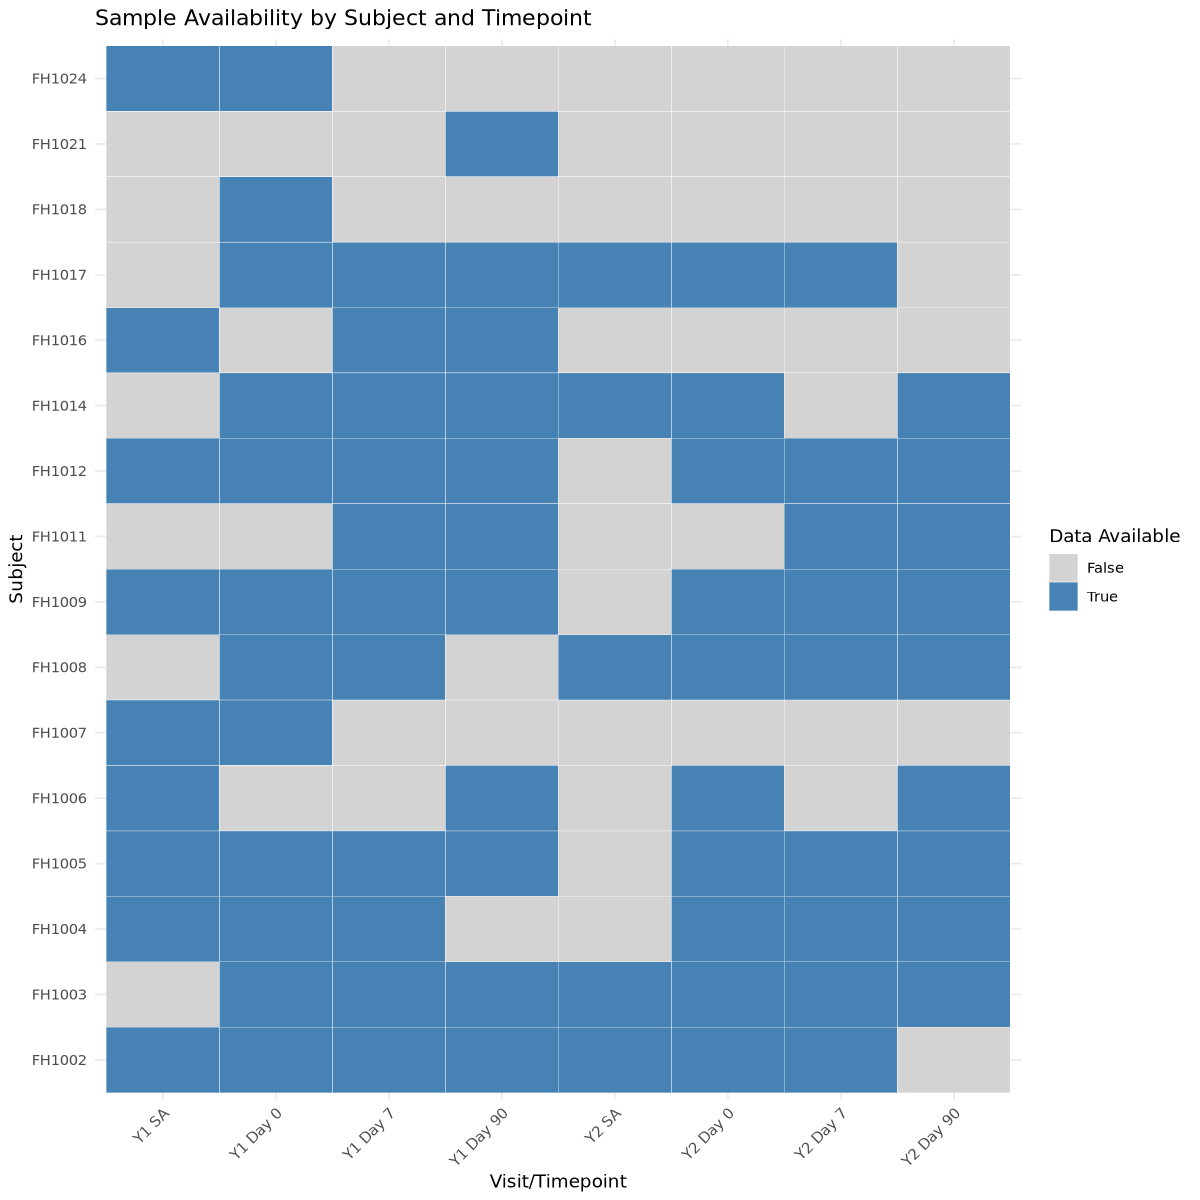

In [3]:
availability_plot <- plot_sample_availability(
    df = df, 
    timepoint_labels = timepoint_labels,
    plot_width = 10,
    plot_height = 10
)

print(availability_plot)

### All Subject-Visit-Celltype combinations with duplicates

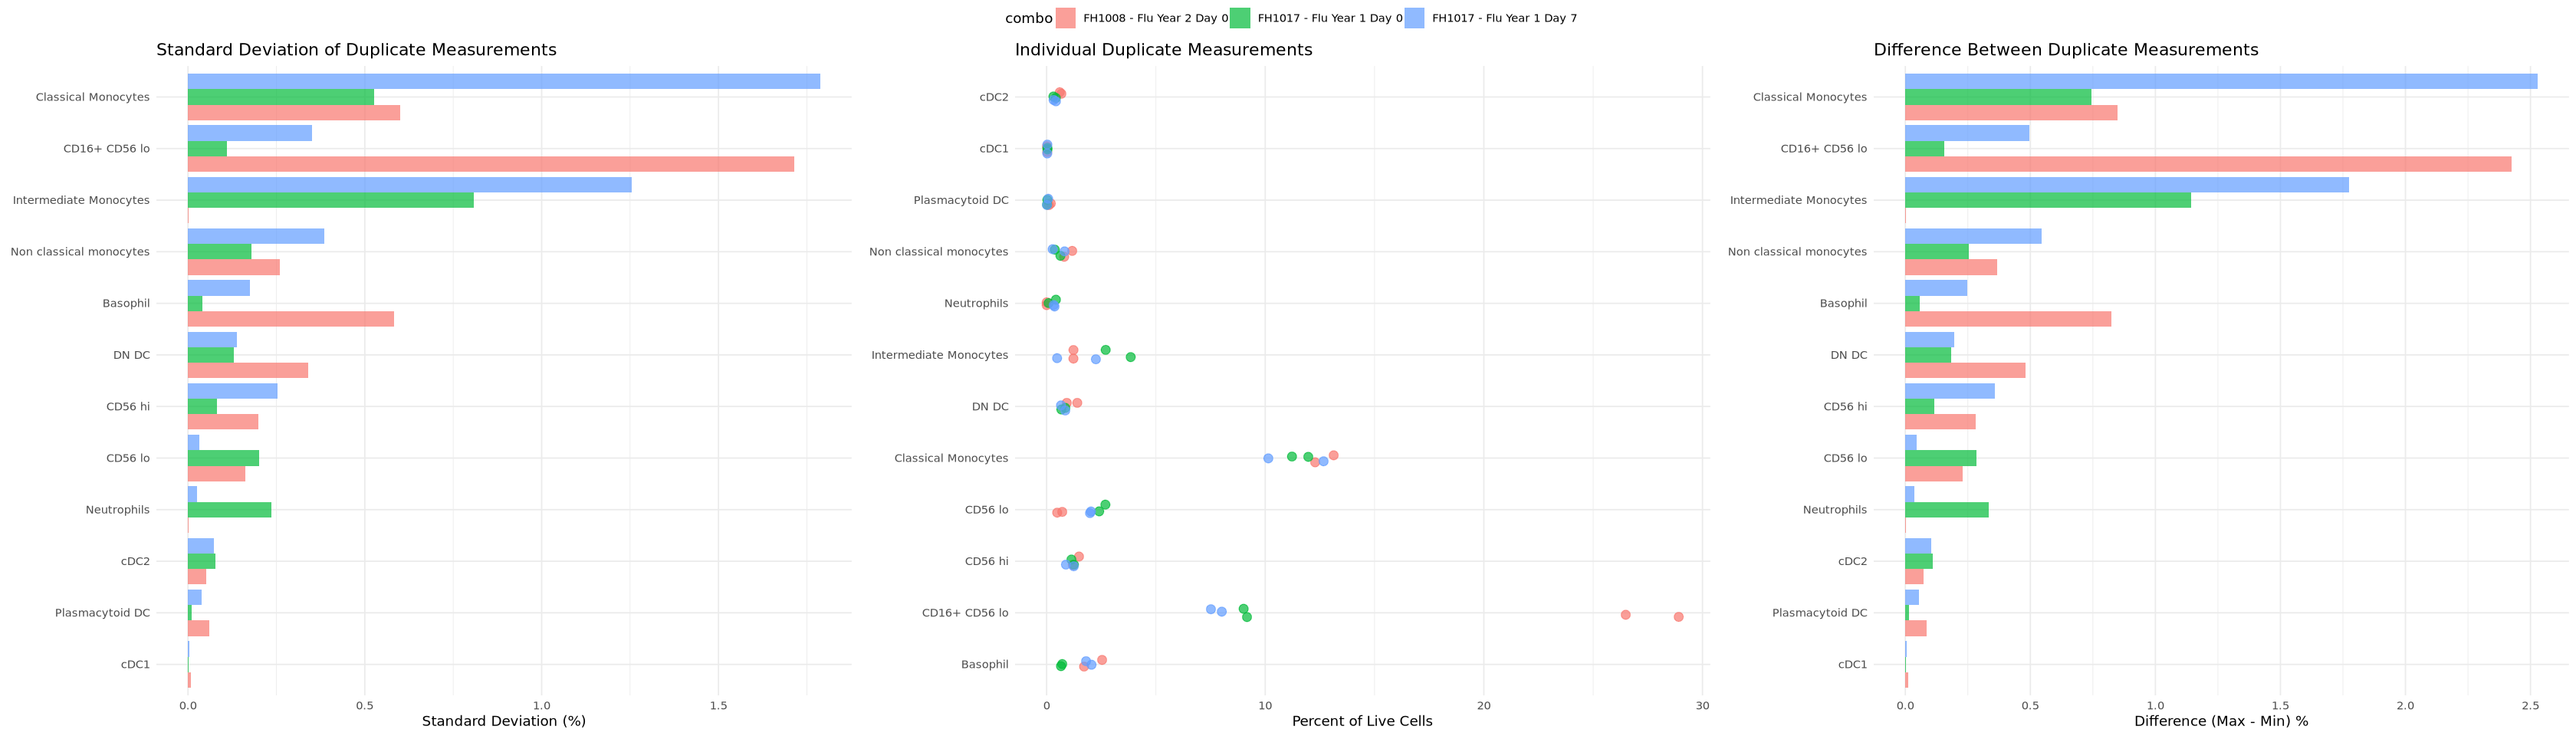

In [4]:
duplicate_analysis <- plot_duplicate_analysis(
    df = df,
    plot_width = 28,
    plot_height = 8
)

print(duplicate_analysis$combined_plot)

## Plotting

### Plotting year 1 & 2

$Y1

$Y2


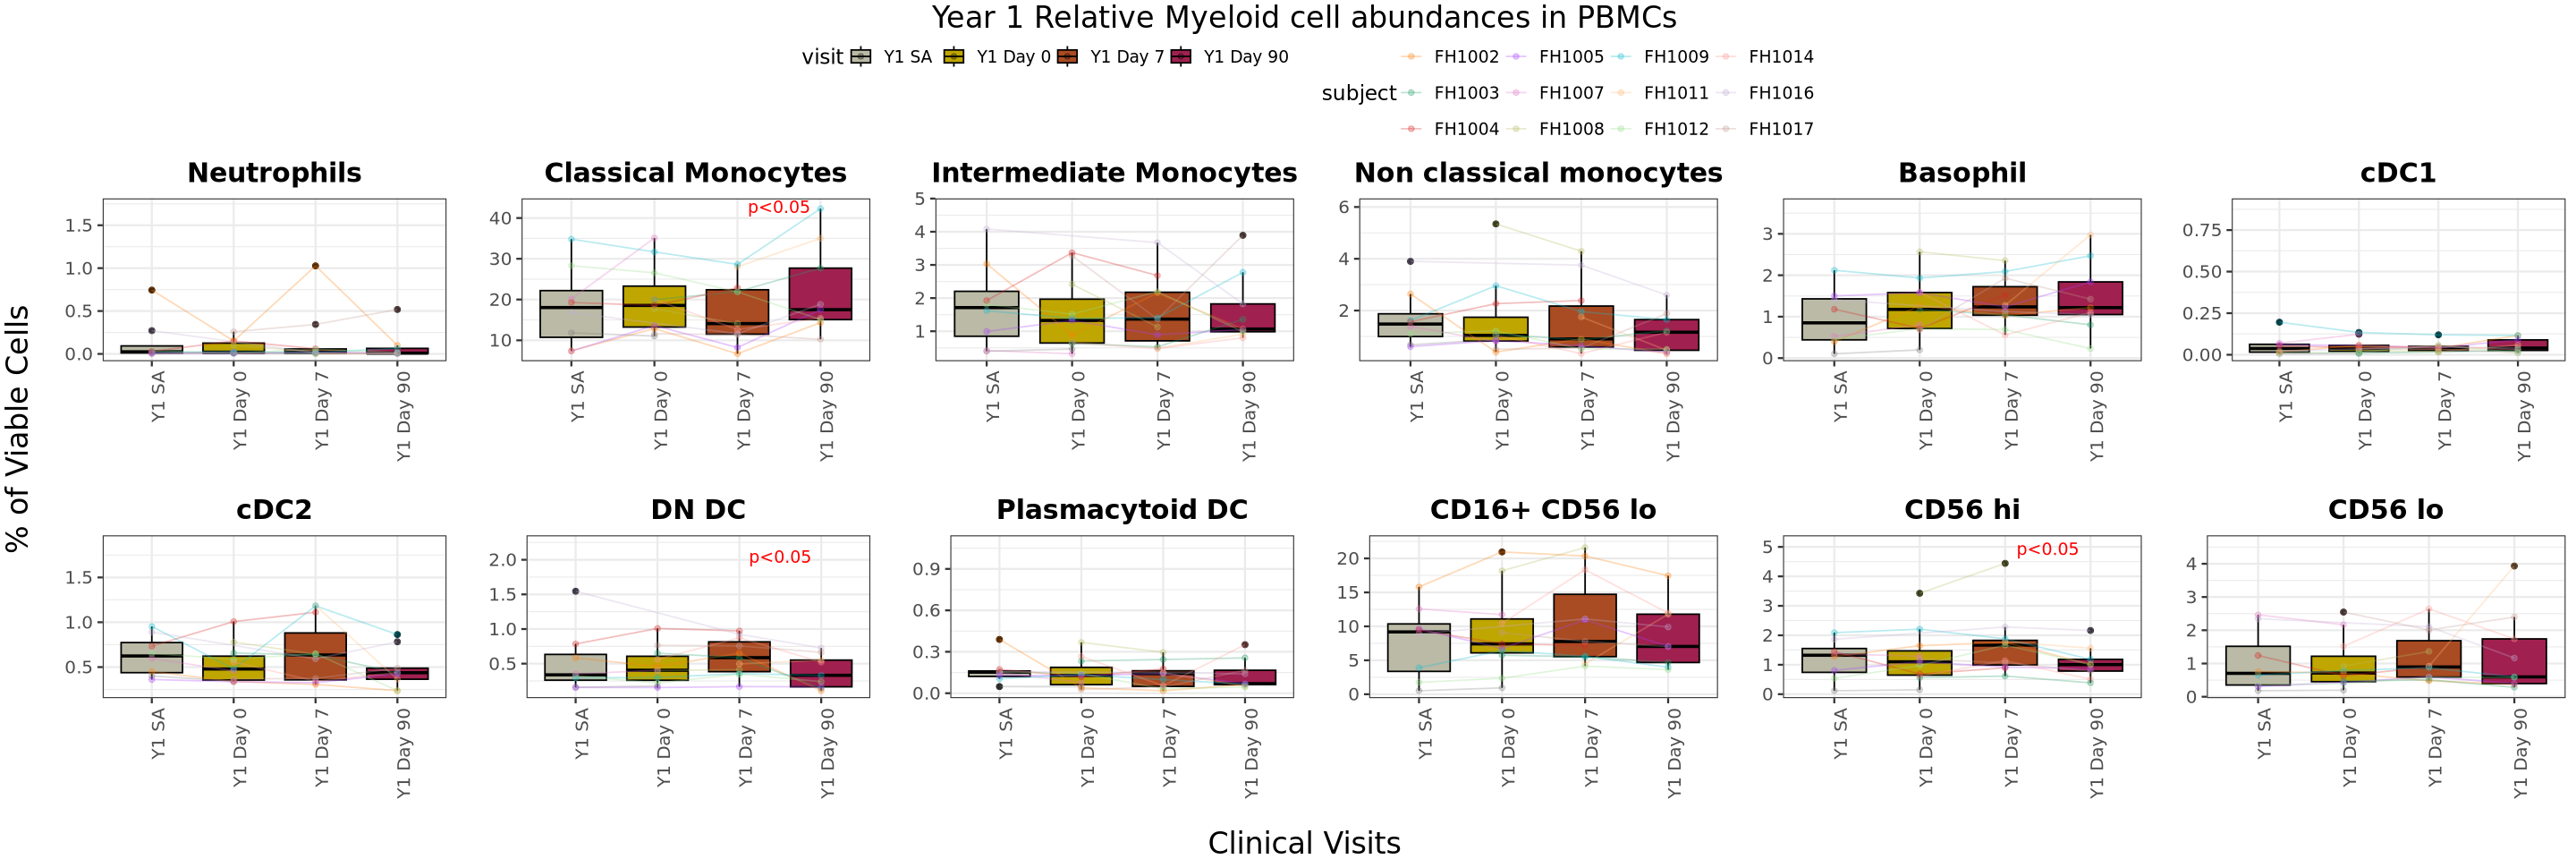

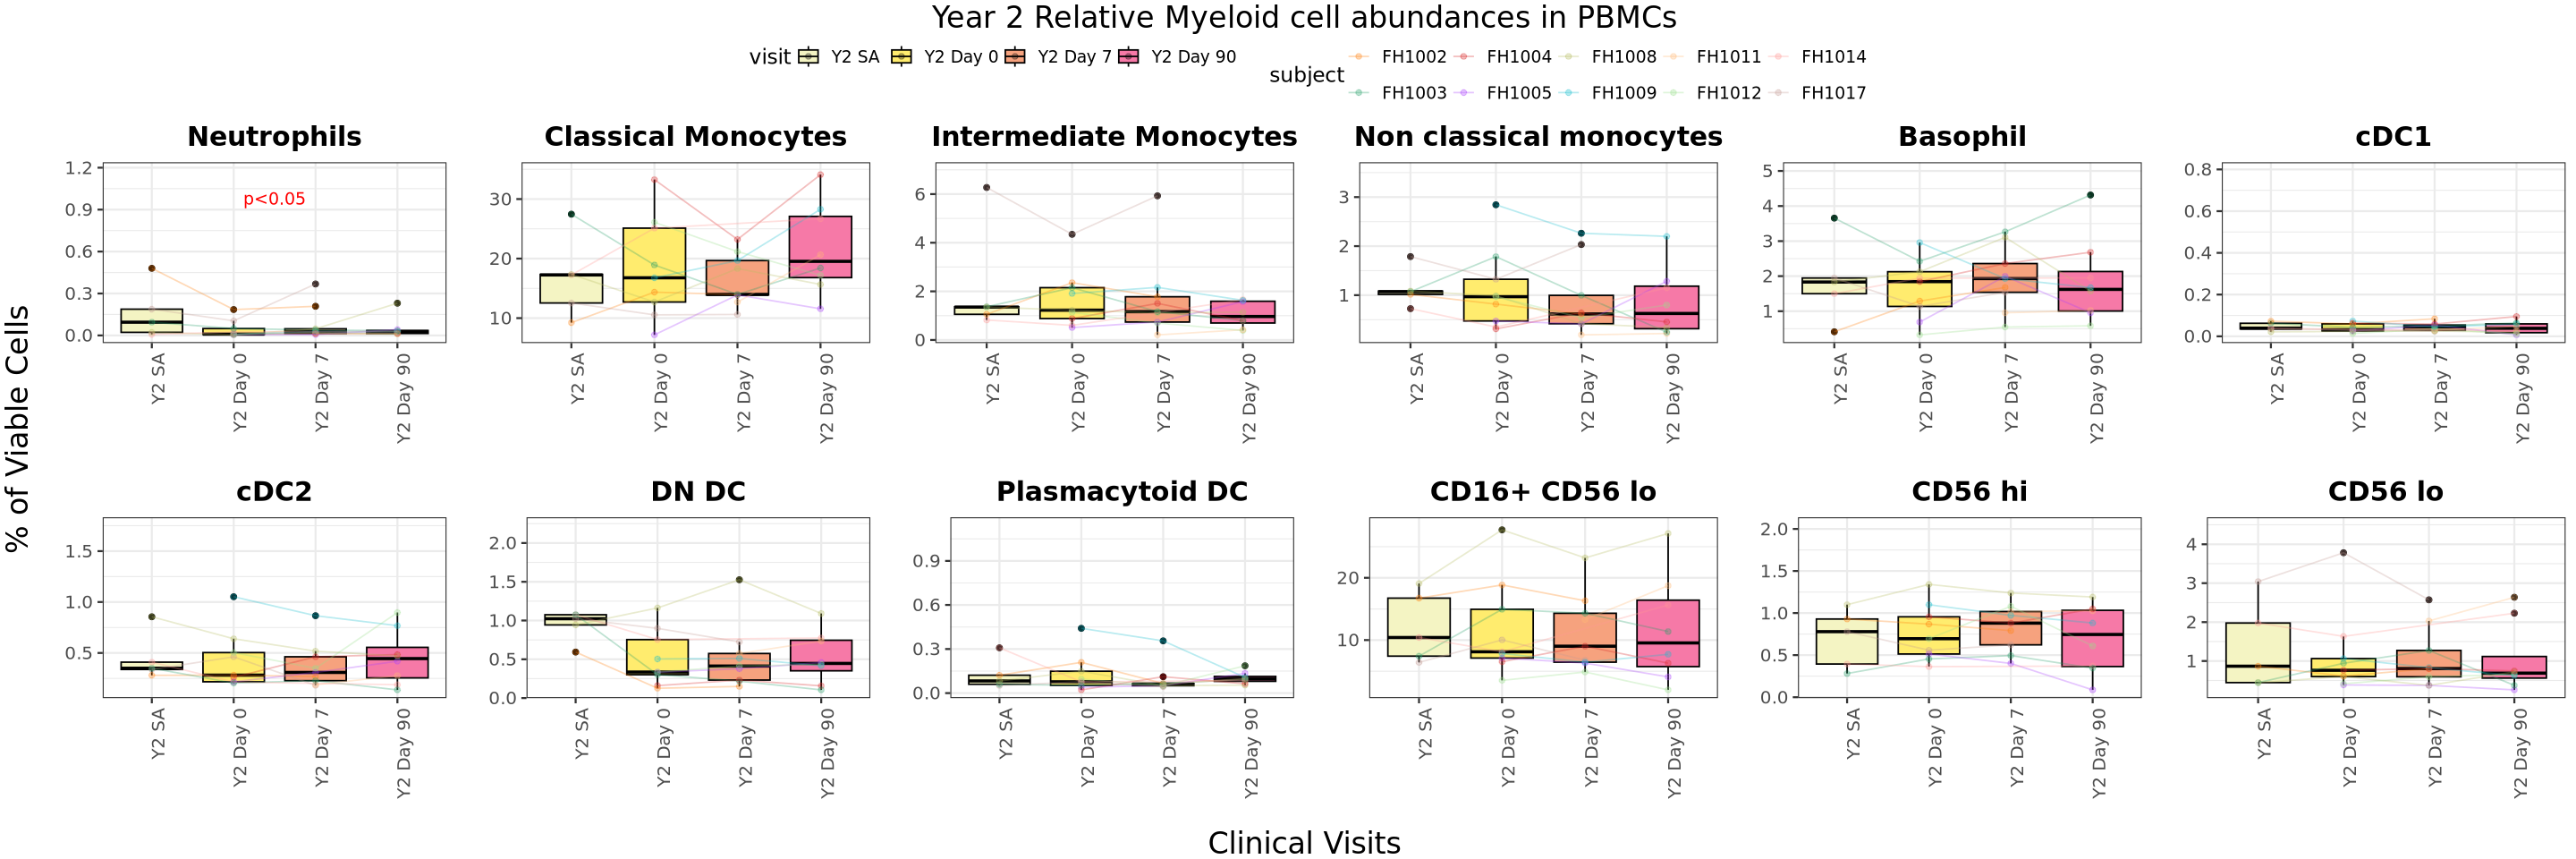

In [8]:
timepoints_pairs <- list(
    Y1 = list(c('Y1 SA','Y1 Day 0'), c('Y1 Day 0','Y1 Day 7'), c('Y1 Day 7', 'Y1 Day 90')),
    Y2 = list(c('Y2 SA','Y2 Day 0'), c('Y2 Day 0','Y2 Day 7'), c('Y2 Day 7', 'Y2 Day 90'))
)

myeloid_plots <- create_longitudinal_cell_plots(
    df = df,
    timepoint_labels = timepoint_labels,
    timepoints_pairs = timepoints_pairs,
    cell_type_name = "Myeloid cell",
    visit_col = "Visit",
    ncol = 6  # or leave NULL for auto-detection
)

print(myeloid_plots)

### Plotting using CLR values

In [4]:
df <- read.csv(file.path(home, path))
names(df)
unique(df$percentOf)

[1] "filename"             "population"           "uniquePopulationName"
 [4] "parentPopulation"     "channel"              "reagent"             
 [7] "Subject"              "Visit"                "Response"            
[10] "Sex"                  "plate"                "plate.row"           
[13] "plate.column"         "plate.well"           "AIFI.barcode"        
[16] "Sample.Kit.Barcode"   "Cohort"               "X"                   
[19] "percentOf"            "percentOfUniqueName"  "percent"

[1] "Total Viable cells"

Warning message in ifelse(!is.na(time1_val) && !is.na(time2_val) && time1_val > :
“NaNs produced”
Warning message in ifelse(!is.na(time1_val) && !is.na(time2_val) && time1_val > :
“NaNs produced”


$Y1

$Y2


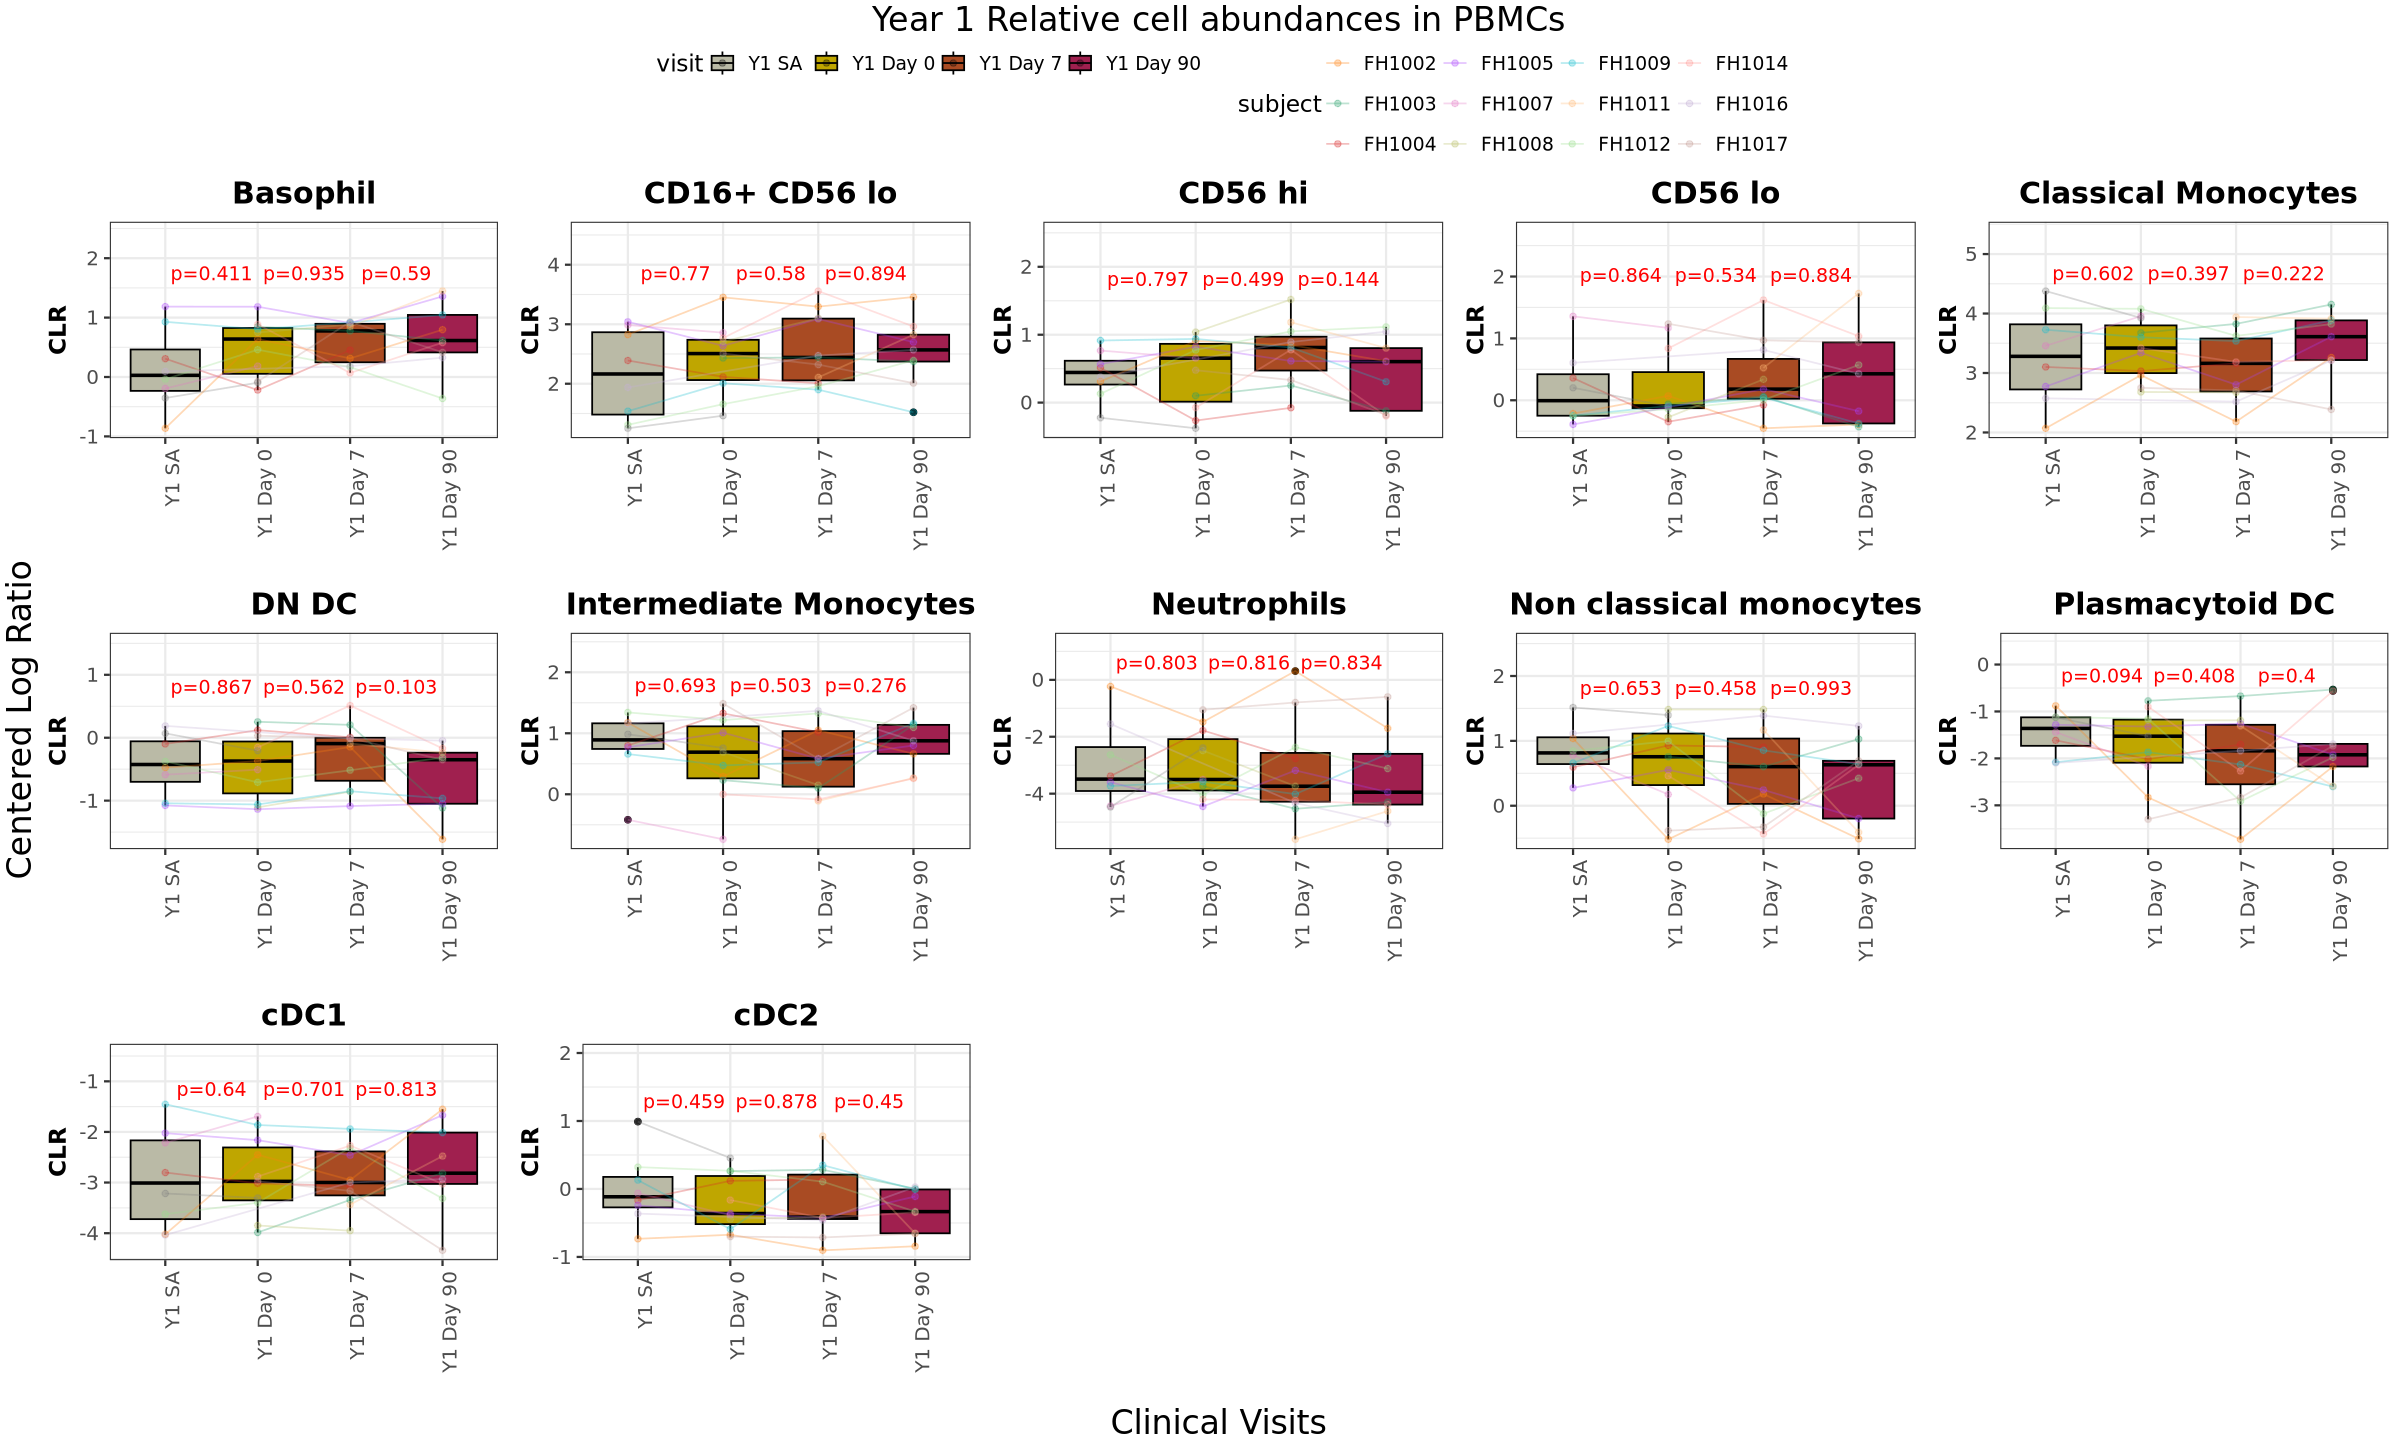

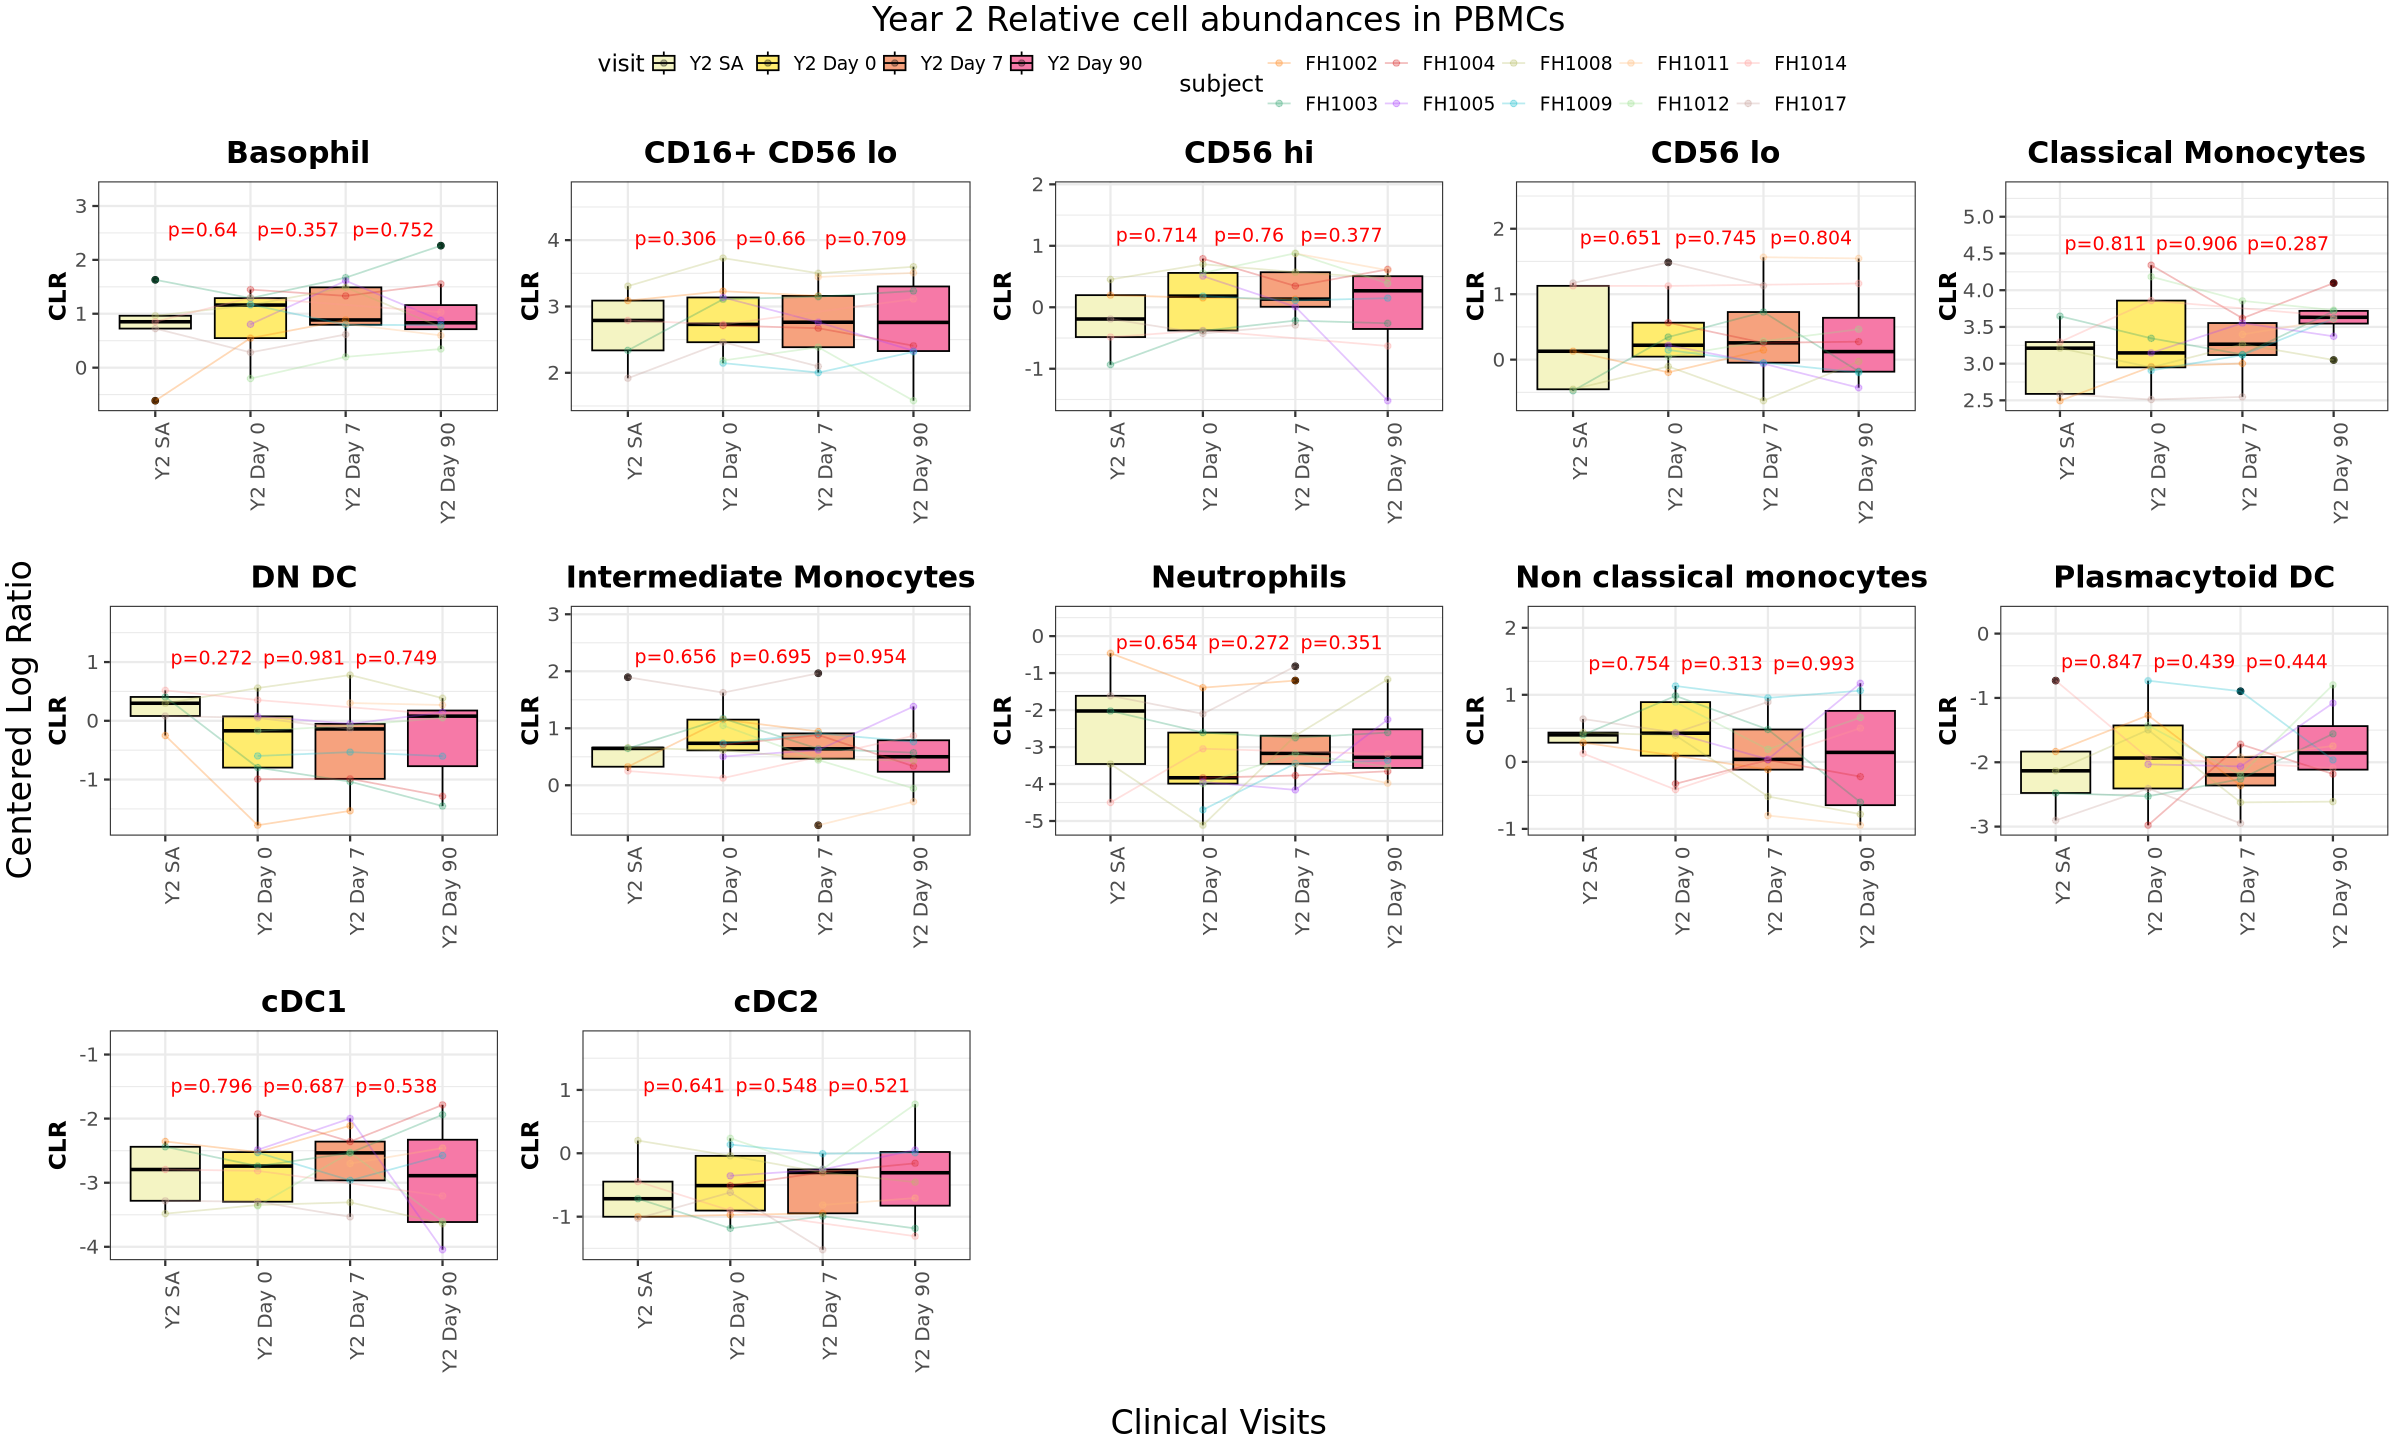

In [6]:
df <- read.csv(file.path(home, path))
df <- process_data(
    df,
    subject_col  = "Subject",
    visit_col = "Visit",
    population_col = "population",
    percent_of_col = "percentOf",
    percent_col = "percent",
    plate_col = "plate",
    celltypes = unique(df$population),
    viable_filter = "Total Viable cells"
)
df <- freq_clr(
    df,
    sample_col = "Sample_ID",
    freq_col = "frequency",
    celltype_col = "population"
)
                                  
# write.csv(df, "/home/workspace/pbmc_flow/data/tcell_longitudinal_composition_clr_results.csv", row.names = FALSE)

timepoints_pairs <- list(
    Y1 = list(c('Y1 SA','Y1 Day 0'), c('Y1 Day 0','Y1 Day 7'), c('Y1 Day 7', 'Y1 Day 90')),
    Y2 = list(c('Y2 SA','Y2 Day 0'), c('Y2 Day 0','Y2 Day 7'), c('Y2 Day 7', 'Y2 Day 90'))
)

plots <- create_longitudinal_cell_plots_clr(
  clr_data = df,
  celltypes = unique(df$population),
  timepoint_labels = timepoint_labels,
  timepoints_pairs = timepoints_pairs,
  population_col = "population",
  show_pval = "all",  # Shows all p-values
  ncol = 5
)

print(plots)